In [1]:
import os, sys
os.sys.path.append('..')
from recommender.utils import mongodbutils as mdb
from recommender.utils.utils import csv2df
from recommender.utils.eval_utils import compute_auc, compute_ap
from recommender.recommender.recommenderMF import RecommenderMF
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

D:\python\Python35\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
D:\python\Python35\lib\site-packages\numpy\.libs\libopenblas.BNVRK7633HSX7YVO2TADGR4A5KEKXJAW.gfortran-win_amd64.dll
D:\python\Python35\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
  stacklevel=1)
D:\python\Python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df_train = pd.read_csv('D:/PycharmProjects/recommender/data/ml-latest-small/ratings_train.csv')
df_test = pd.read_csv('D:/PycharmProjects/recommender/data/ml-latest-small/ratings_test.csv')

In [3]:
model_path = 'D:/PycharmProjects/recommender/recommender/models/model/06201922232424/'
rmf = RecommenderMF(mode='predict', model_path=model_path)

INFO:tensorflow:Restoring parameters from D:/PycharmProjects/recommender/recommender/models/model/06201922232424/variables\variables


In [4]:
df_test_rel = df_test[df_test['rating']>3.0]
df_test_rel.head()

,Unnamed: 0,user,item,rating,item_cat,user_cat
3,48709,314,127,4.0,127,314
6,63051,413,1644,4.0,1644,413
8,51171,329,4328,4.0,4328,329
10,15330,99,485,4.5,485,99
11,57650,379,5856,4.0,5856,379


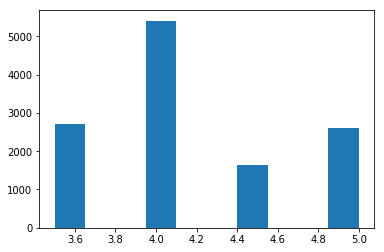

In [5]:
plt.hist(df_test_rel['rating'])
plt.show()

In [6]:
# remove train info from testing
user = 33
df_test_excl = df_train.loc[df_train.user==user]

rec = rmf.recommend(user)[0]
rec_filt = pd.DataFrame({'item': rec}, )
rec_filt = pd.merge(rec_filt, df_test_excl ,on="item", how="outer",indicator=True)
rec_filt = rec_filt.loc[rec_filt._merge=='left_only']['item']
print(len(rec), len(rec_filt))

9724 9650


9650 9


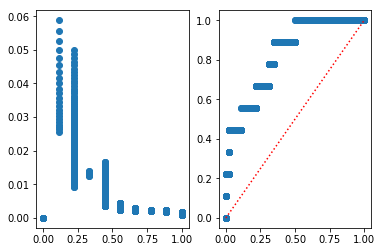

In [7]:
pos = df_test_rel[df_test_rel['user']==user]['item']

pos = set(pos)
n = len(rec_filt)
p = len(pos)

print(n, p)

f = n - p
tp = 0
fp = 0
prec = []
sens = []
fpr = []
tp_pos = []

for i, r in enumerate(rec_filt):
    if r in pos:
        tp += 1
        tp_pos.append(i)
    else:
        fp += 1
    prec.append(tp/(i+1))
    sens.append(tp/p)
    fpr.append(fp/f)

plt.subplot(121)
plt.plot(sens, prec, 'o')
plt.subplot(122)
plt.plot(fpr, sens, 'o')
plt.plot([0,1], [0,1], 'r:')
plt.show()

In [8]:
prec = np.array(prec)
sens = np.array(sens)
fpr = np.array(fpr)
dsens = sens[1:] - sens[:-1]
dfpr = fpr[1:] - fpr[:-1]
print(np.sum(prec[1:]*dsens))
print(np.sum(sens[1:]*dfpr))

0.01703755308998961
0.8280837626341205


In [9]:
compute_auc(rmf, user, df_test_rel, df_train)

0.8280837626341204

In [10]:
compute_ap(rmf, user, df_test_rel, df_train)

0.017037553089989613

In [11]:
a,s = rmf.similar_to(3)

(9724, 10) (10,)


In [18]:
from recommender.utils.ItemMetadata import ItemMetadataFromCSV
md = ItemMetadataFromCSV('D:/PycharmProjects/recommender/data/tmp/item_map_df.csv',
                        'D:/PycharmProjects/recommender/data/ml-latest-small/movies.csv',
                         'idx', 'movieId', 'item_cat', ['title']
                        )

          movieId                               title  \
item_cat                                                
0               1                    Toy Story (1995)   
481             2                      Jumanji (1995)   
1               3             Grumpier Old Men (1995)   
482             4            Waiting to Exhale (1995)   
483             5  Father of the Bride Part II (1995)   

                                               genres  idx  
item_cat                                                    
0         Adventure|Animation|Children|Comedy|Fantasy    1  
481                        Adventure|Children|Fantasy    2  
1                                      Comedy|Romance    3  
482                              Comedy|Drama|Romance    4  
483                                            Comedy    5  


In [21]:
md.fetch_md(a)

,title
item_cat,
6700,Caddyshack II (1988)
6336,Frankie and Johnny (1991)
5496,Blackbeard's Ghost (1968)
7623,Paradise Now (2005)
6741,Pauline at the Beach (Pauline à la Plage) (1983)
7513,Running Scared (1980)
9307,Idaho Transfer (1973)
6355,Taking Woodstock (2009)
8230,Eddie and the Cruisers (1983)
